In [1]:
# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('ticks')

In [2]:
# munging
import os

In [3]:
# science
from starfish import IntensityTable, Experiment, ImageStack
from starfish.plot.intensity_table import compare_copy_number, spot_area_histogram, spot_distance_histogram, barcode_magnitude_histogram
from starfish.plot import spots
from starfish.types import Indices
import numpy as np
import pandas as pd

from showit import image

## Load IntensityTables

In [4]:
# IntensityTable can't download from directories without list privileges

data_root = "https://dmf0bdeheu4zf.cloudfront.net/assay_comparison/"
iss_link = data_root + "iss.nc"
merfish_link = data_root + "merfish.nc"
dartfish_link = data_root + "dartfish.nc"

tmp = os.environ['TMPDIR']
iss_nc = tmp + "iss.nc"
merfish_nc = tmp + "merfish.nc"
dartfish_nc = tmp + "dartfish.nc"


!curl -o $iss_nc $iss_link
!curl -o $merfish_nc $merfish_link
!curl -o $dartfish_nc $dartfish_link

iss = IntensityTable.load(iss_nc)
merfish = IntensityTable.load(merfish_nc)
dartfish = IntensityTable.load(dartfish_nc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  700k  100  700k    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0  1922k      0 --:--:-- --:--:-- --:--:-- 1928k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5450k  100 5450k    0     0  9006k      0 --:--:-- --:--:-- --:--:-- 8994k     0      0      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83532  100 83532    0     0   373k      0 --:--:-- --:--:-- --:--:--  374k


In [5]:
datasets = [iss, merfish, dartfish]

## Load Background Images

In [6]:
# construct background images for each assay
stack = Experiment.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180821/DARTFISH/fov_001/experiment.json')

dartfish_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)
dartfish_link = data_root + "dartfish_dots_image.npy"
dartfish_npy = tmp + "dartfish.npy"
!curl -o $dartfish_npy $dartfish_link
dartfish_dots = np.load(dartfish_npy)

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 7626k  100 7626k    0     0  11.1M      0 --:--:-- --:--:-- --:--:-- 11.1M


In [7]:
stack = Experiment.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180821/ISS/fov_001/experiment.json')

iss_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)
iss_dots = stack.auxiliary_images['dots'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


In [8]:
stack = Experiment.from_json('https://dmf0bdeheu4zf.cloudfront.net/20180802/MERFISH/fov_001/experiment.json')
merfish_nuclei = stack.auxiliary_images['nuclei'].max_proj(Indices.CH, Indices.ROUND, Indices.Z)

# merfish doesn't have a dots image, and some of the channels are stronger than others. We can use the scale factors to get the right levels
merfish_background = stack.image.max_proj(Indices.CH, Indices.ROUND)
merfish_background = np.reshape(merfish_background, (1, 1, *merfish_background.shape))
merfish_background = ImageStack.from_numpy_array(merfish_background)

from starfish.image import Filter
clip = Filter.Clip(p_max=99.7)
merfish_dots = clip.run(merfish_background, in_place=False)

merfish_dots = merfish_dots.max_proj(Indices.CH, Indices.ROUND, Indices.Z)

100%|██████████| 1/1 [00:00<00:00, 2347.12it/s]


## Load Decoded Images

Numpy load can't download files from s3 either.

In [9]:
merfish_link = data_root + "merfish_decoded_image.npy"
dartfish_link = data_root + "dartfish_decoded_image.npy"

merfish_npy = tmp + "merfish_decoded_image.npy"
dartfish_npy = tmp + "dartfish_decoded_image.npy"

!curl -o $merfish_npy $merfish_link
!curl -o $dartfish_npy $dartfish_link


merfish_decoded_image = np.squeeze(np.load(merfish_npy))
dartfish_decoded_image = np.squeeze(np.load(dartfish_npy))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.0M  100 32.0M    0     0  20.6M      0  0:00:01  0:00:01 --:--:-- 20.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7626k  100 7626k    0     0  9707k      0 --:--:-- --:--:-- --:--:-- 9702k  0     0  8004k      0 --:--:-- --:--:-- --:--:-- 8000k


## Show Different Background Types for MERFISH

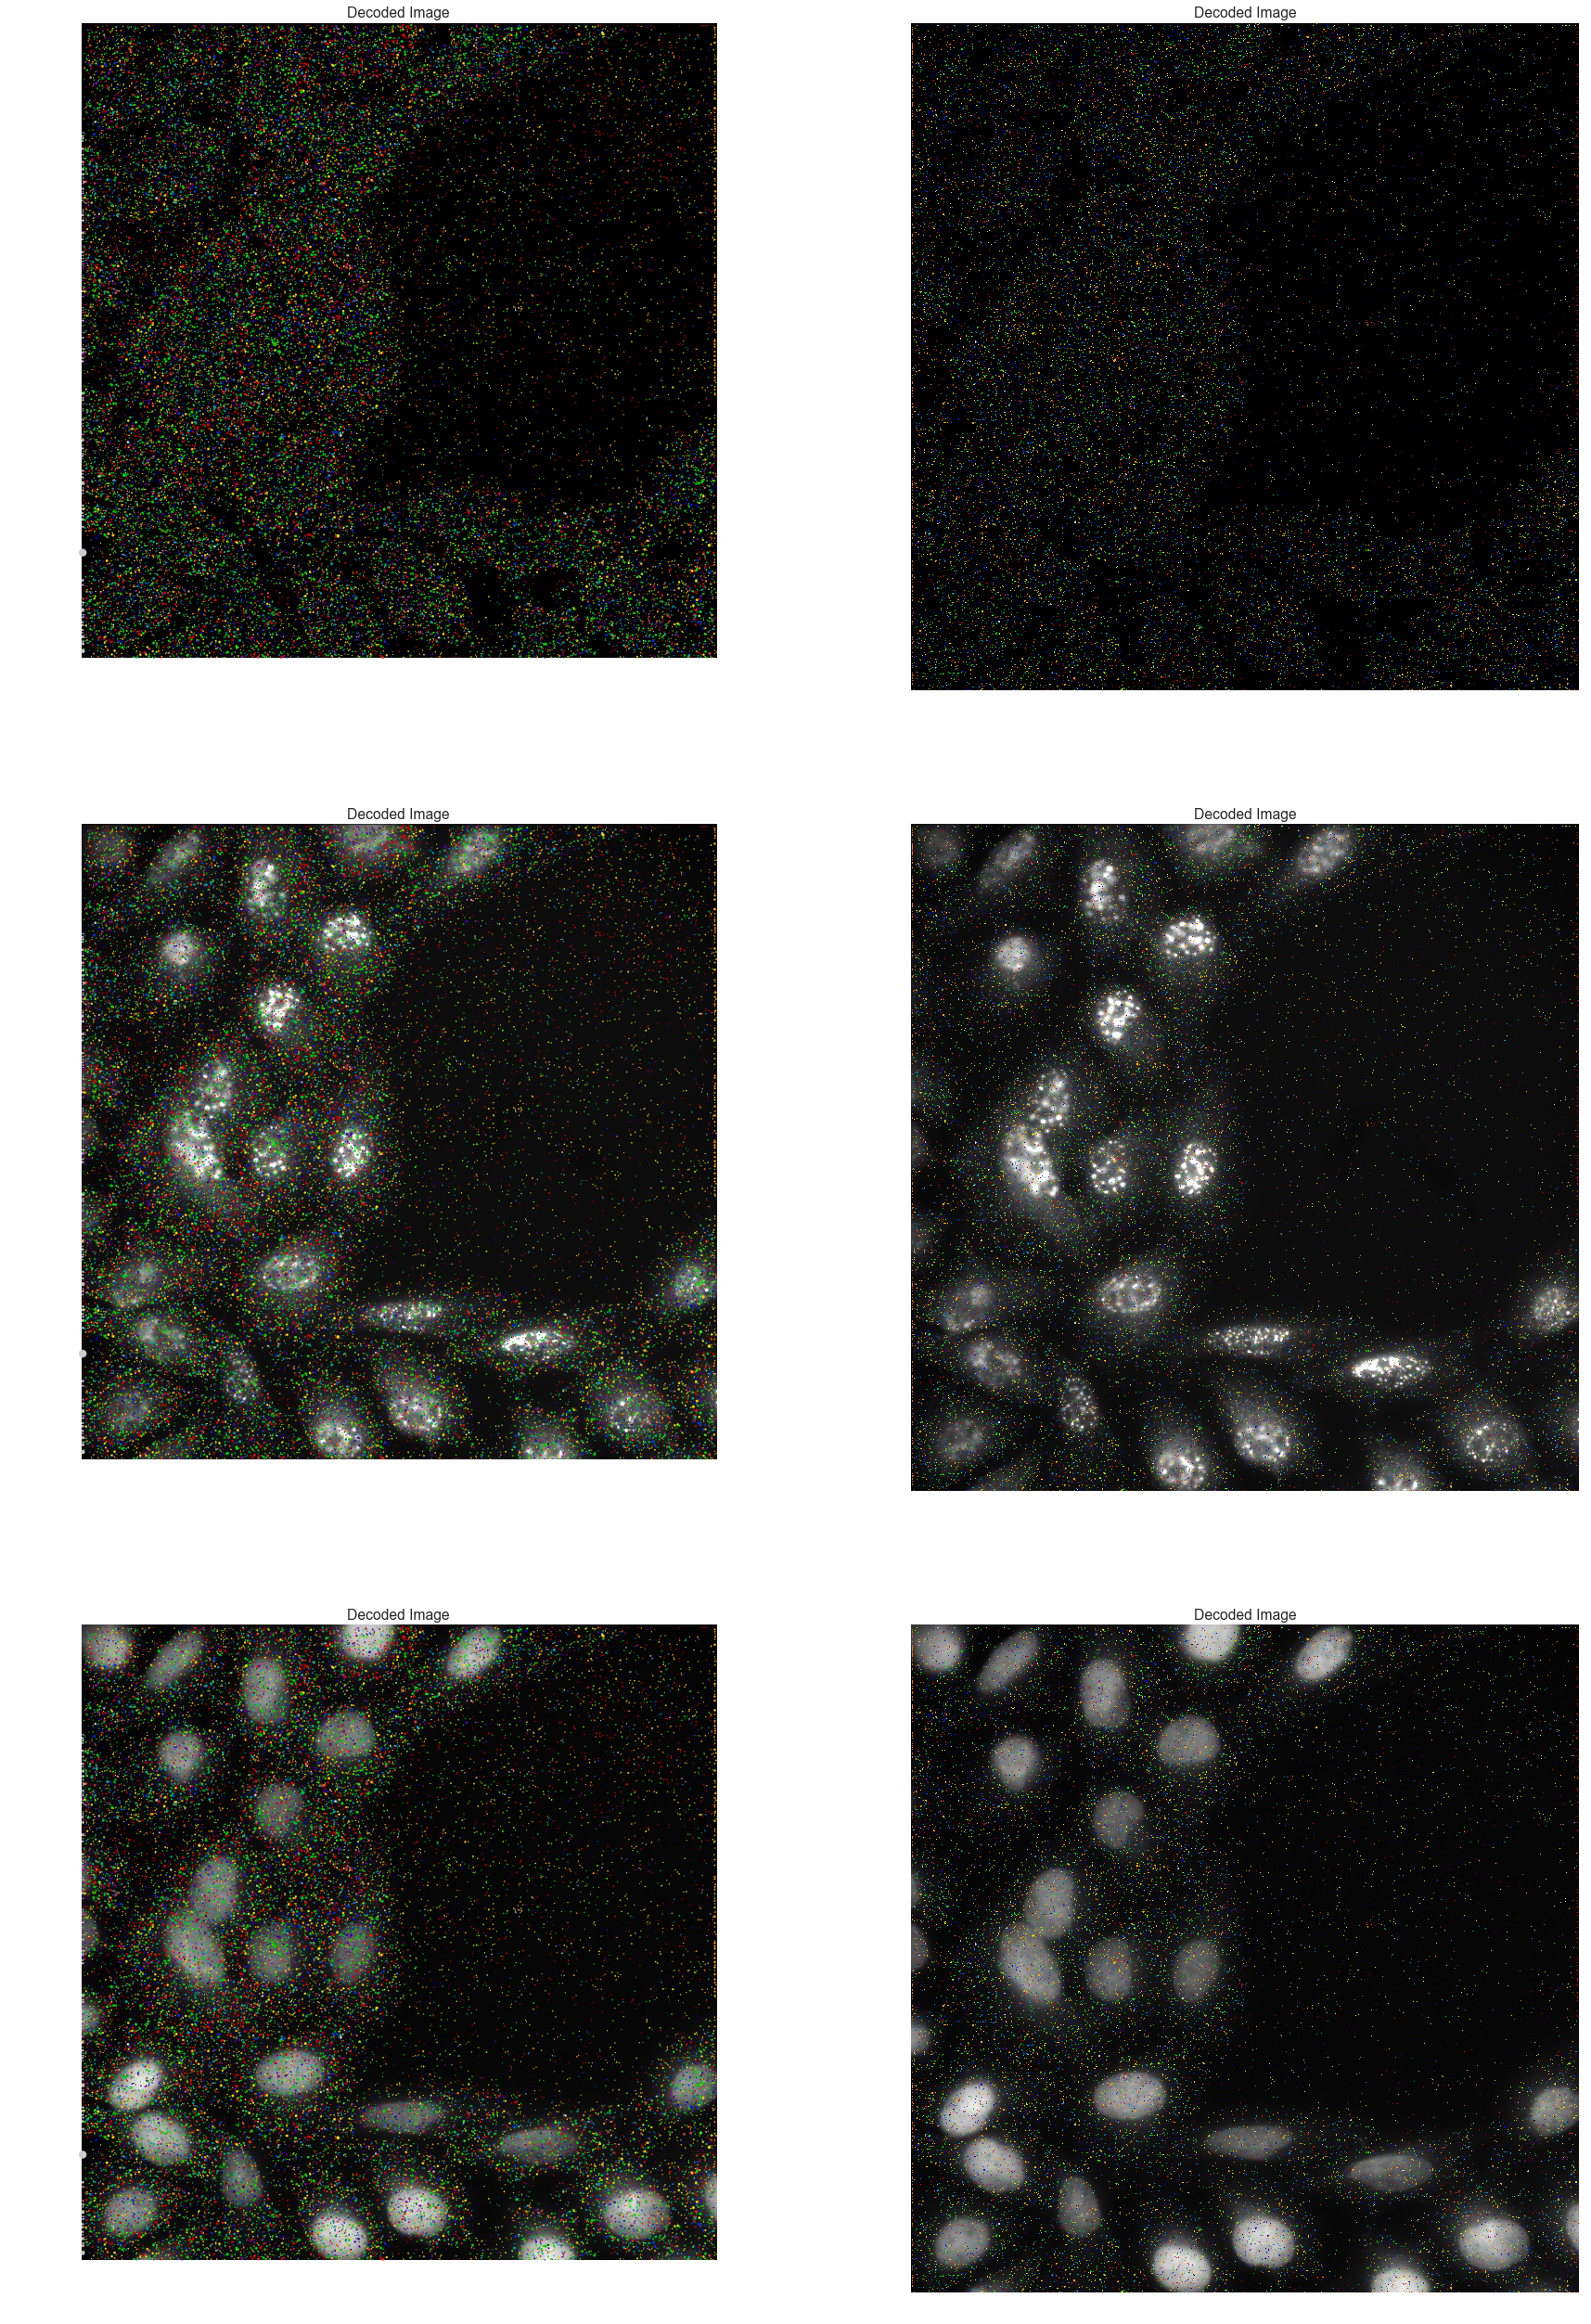

In [10]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 45))
spots(merfish, background_image=np.zeros_like(merfish_dots), spots_kwargs=dict(alpha=1.), ax=ax1)
spots(merfish, background_image=merfish_dots, spots_kwargs=dict(alpha=1.), ax=ax3)
spots(merfish, background_image=merfish_nuclei, spots_kwargs=dict(alpha=1.), ax=ax5)
spots(decoded_image=merfish_decoded_image, decoded_image_kwargs=dict(alpha=1.), ax=ax2)
spots(decoded_image=merfish_decoded_image, background_image=merfish_dots, decoded_image_kwargs=dict(alpha=1.), ax=ax4)
spots(decoded_image=merfish_decoded_image, background_image=merfish_nuclei, decoded_image_kwargs=dict(alpha=1.), ax=ax6);

From these examples, we can see that the point cloud over-estimates the spot size (perhaps we're calculating radius wrong?)

## Show different Dartfish Spots Plots

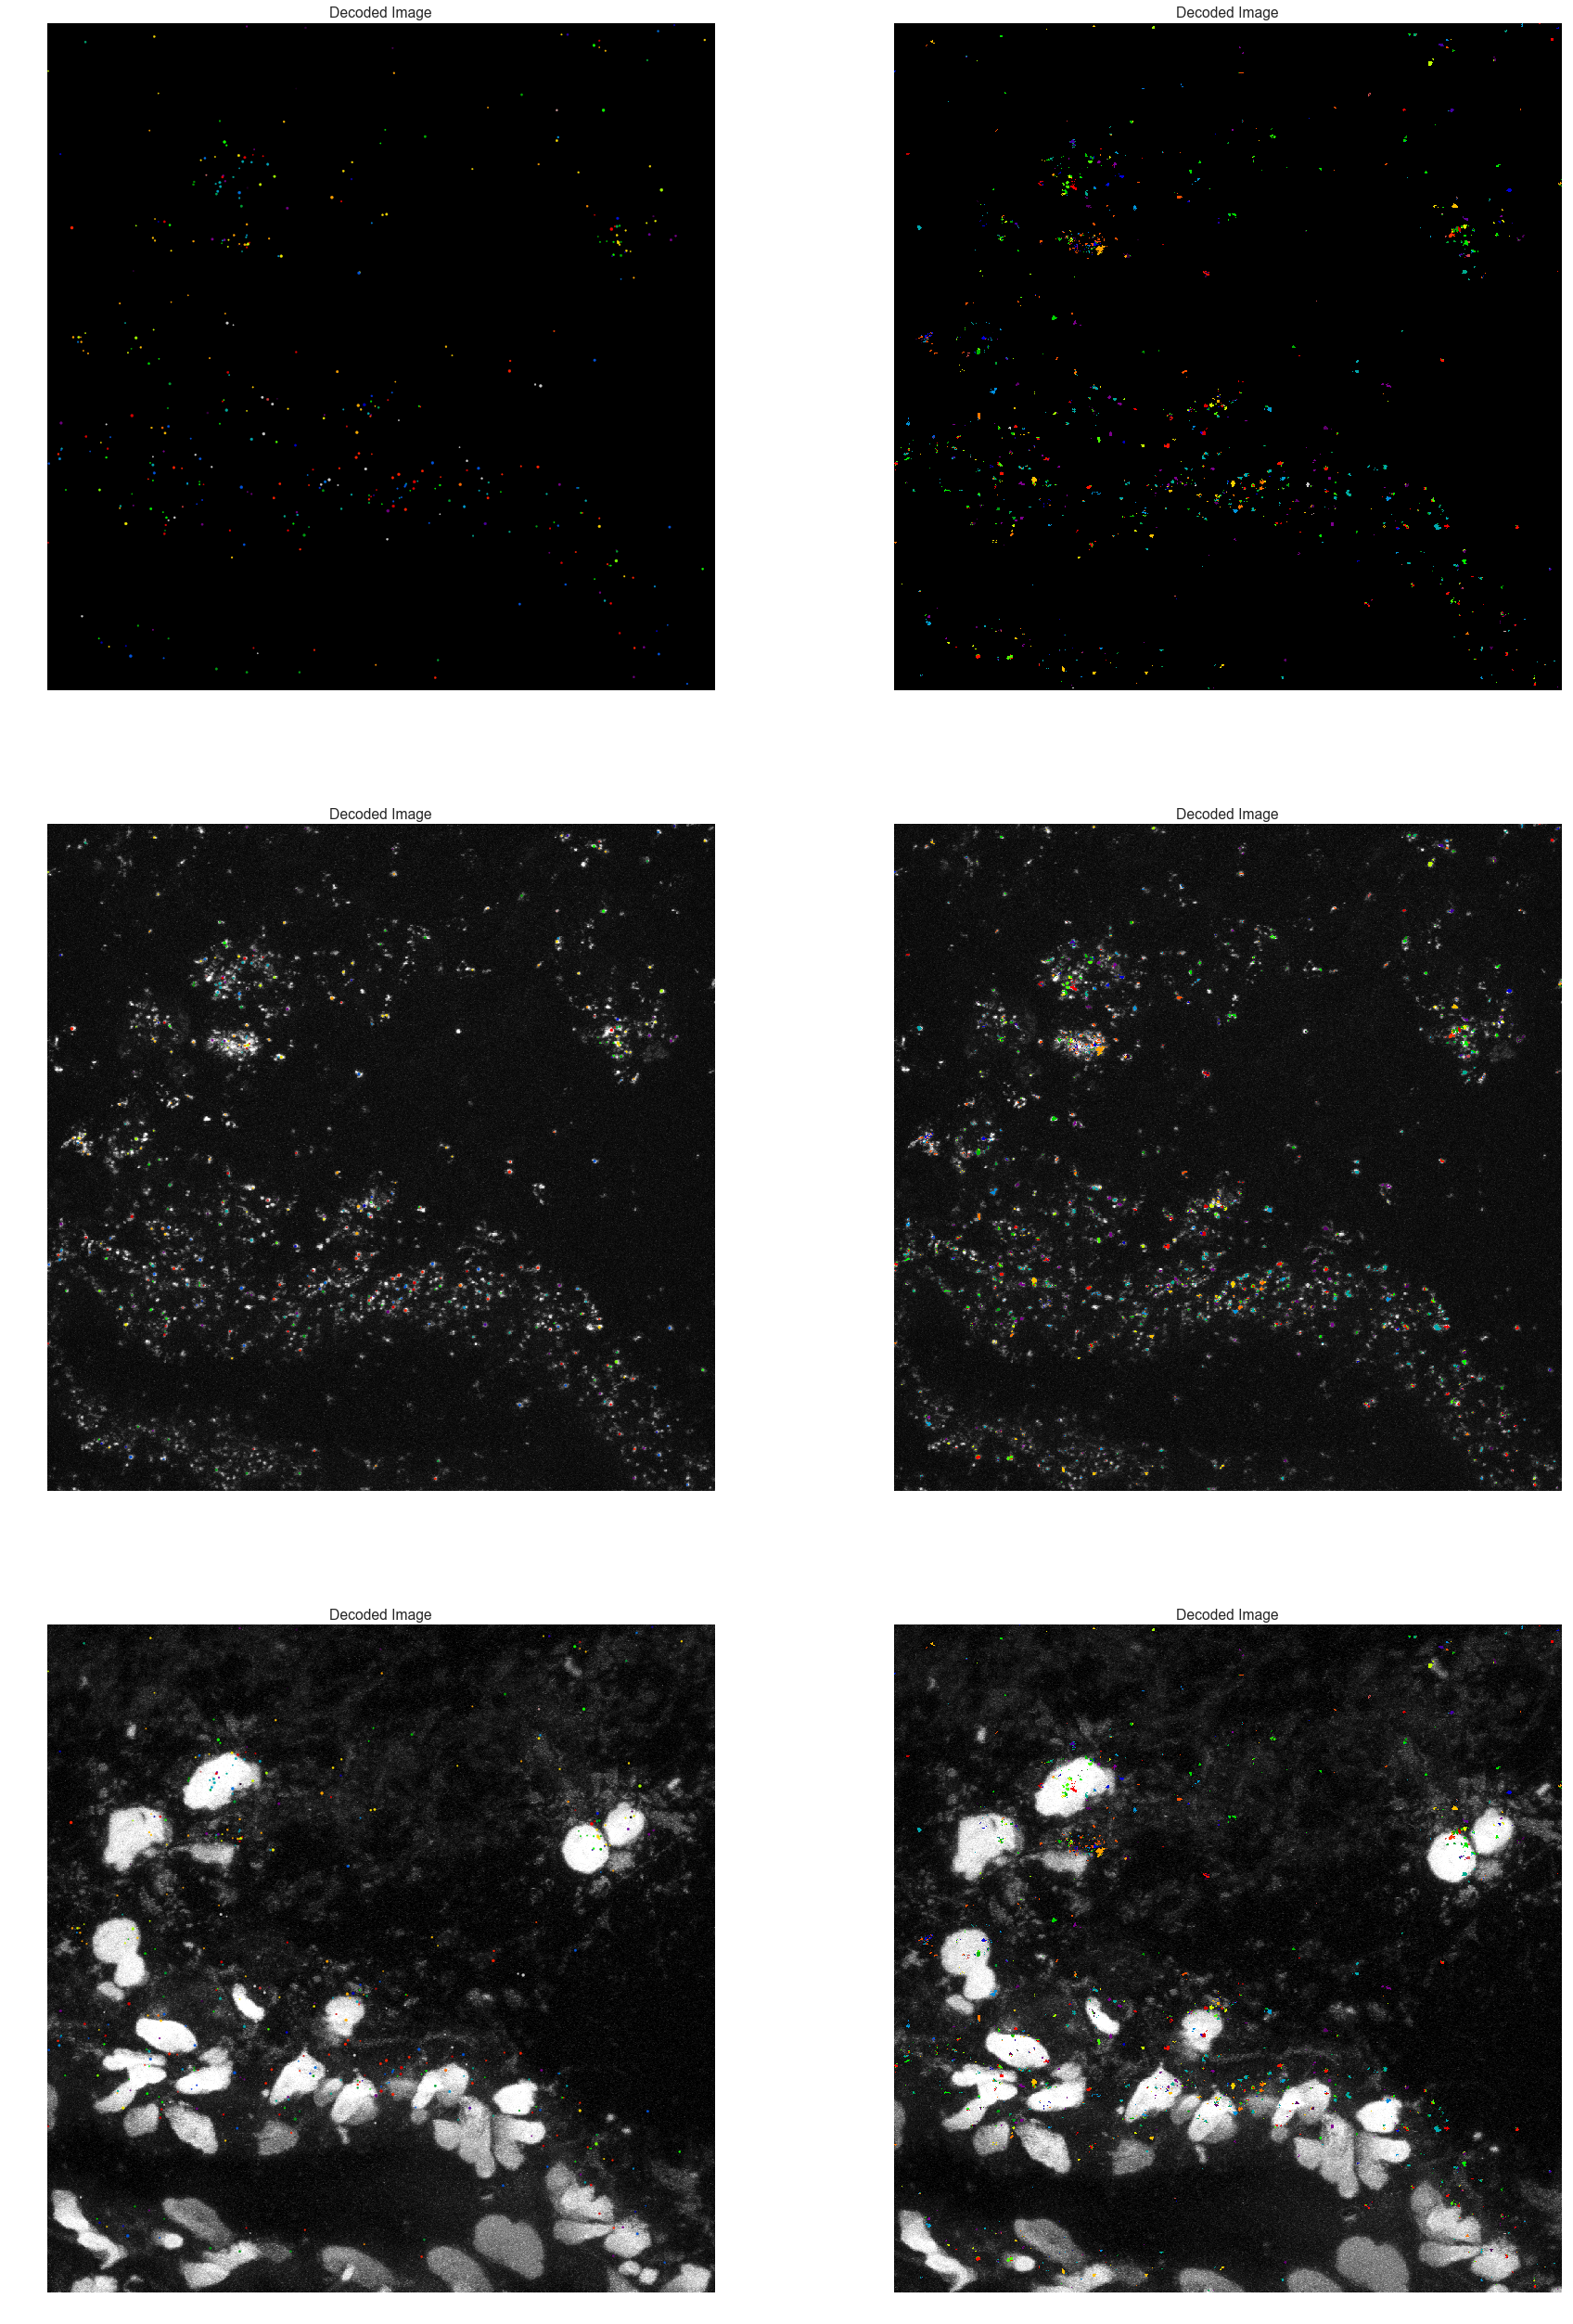

In [11]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 45))
spots(dartfish, background_image=np.zeros_like(dartfish_dots), spots_kwargs=dict(alpha=1.), ax=ax1)
spots(dartfish, background_image=dartfish_dots, spots_kwargs=dict(alpha=1.), ax=ax3)
spots(dartfish, background_image=dartfish_nuclei, spots_kwargs=dict(alpha=1.), ax=ax5)
spots(decoded_image=dartfish_decoded_image, decoded_image_kwargs=dict(alpha=1.), ax=ax2)
spots(decoded_image=dartfish_decoded_image, background_image=dartfish_dots, decoded_image_kwargs=dict(alpha=1.), ax=ax4)
spots(decoded_image=dartfish_decoded_image, background_image=dartfish_nuclei, decoded_image_kwargs=dict(alpha=1.), ax=ax6);

## Show different background types for ISS

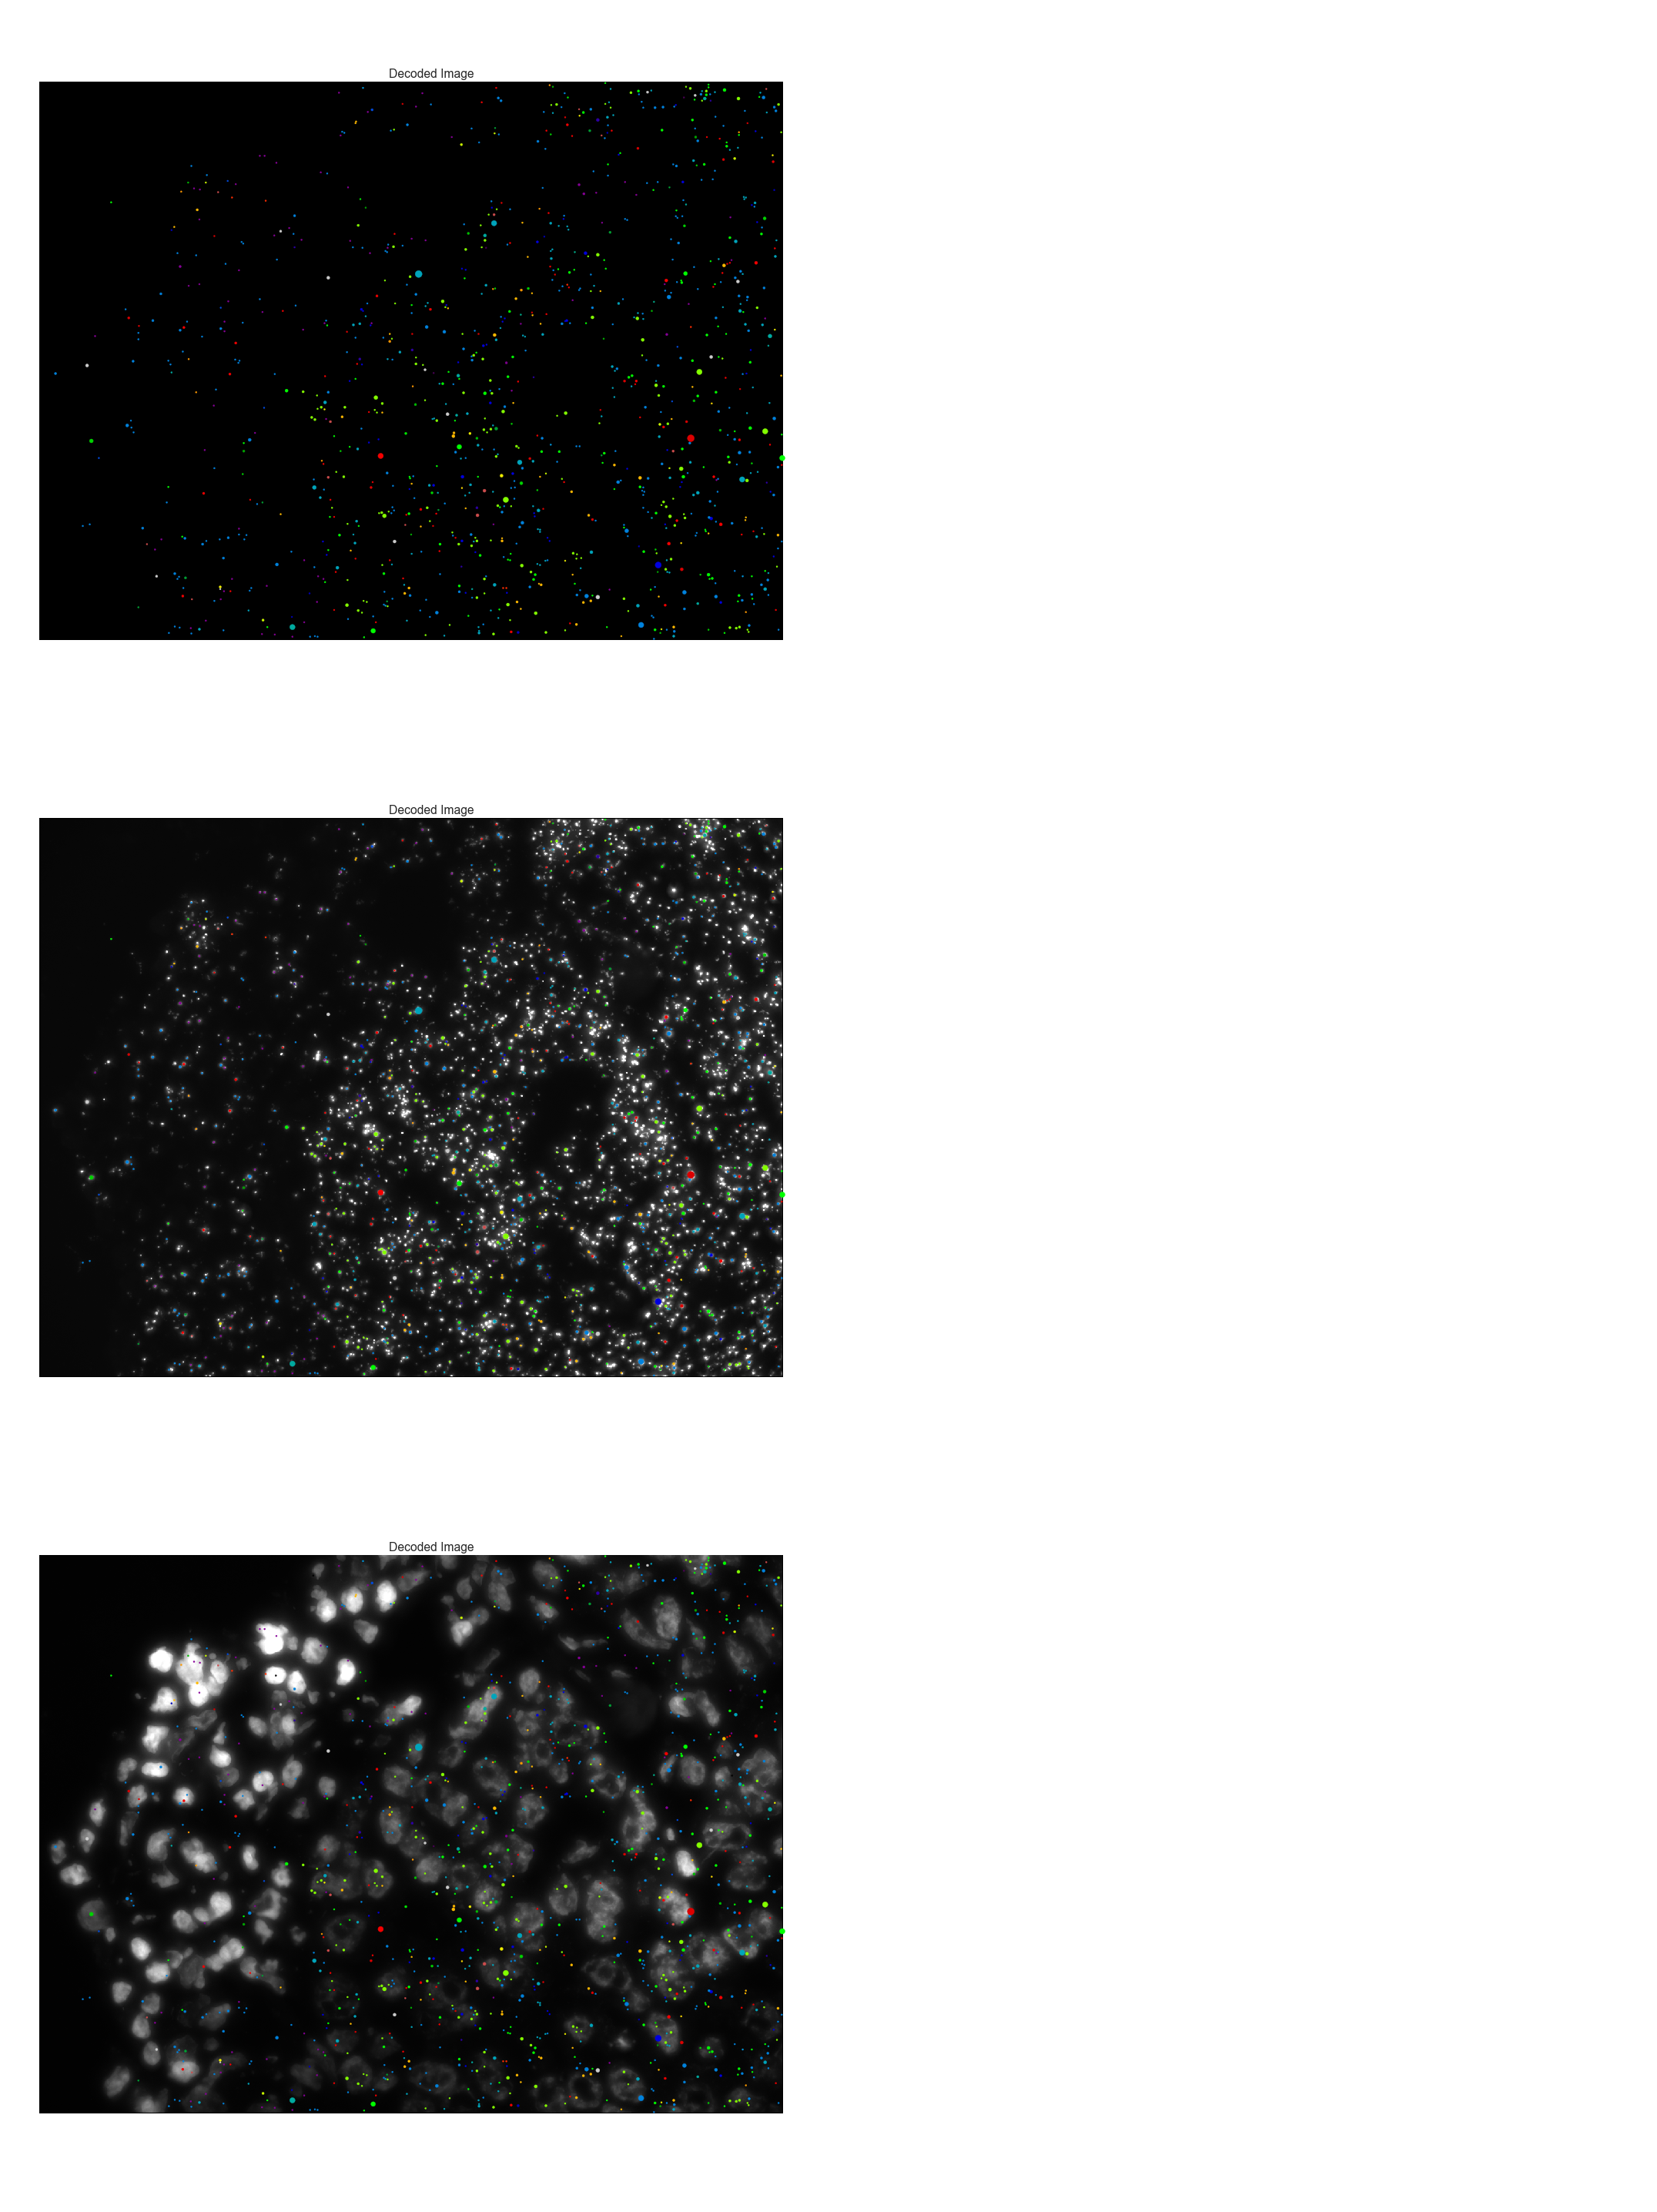

In [12]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(30, 40))
spots(iss, background_image=np.zeros_like(iss_dots), spots_kwargs=dict(alpha=1.), ax=ax1)
spots(iss, background_image=iss_dots, spots_kwargs=dict(alpha=1.), ax=ax3)
spots(iss, background_image=iss_nuclei, spots_kwargs=dict(alpha=1.), ax=ax5)

# ISS doesn't have a decoded image, so leave those plots blank to make this clear
for ax in (ax2, ax4, ax6):
    ax.set_axis_off()
f.tight_layout()

## Download available copy number information from original authors

In [13]:
dartfish_copy_number = pd.read_csv('https://dmf0bdeheu4zf.cloudfront.net/20180821/DARTFISH/fov_001/counts.csv', index_col=0, squeeze=True)
merfish_copy_number = pd.read_csv(data_root + "merfish_copy_number_benchmark.csv", index_col=0, squeeze=True)
iss_copy_number = pd.read_csv(data_root + "iss_copy_number_benchmark.csv", index_col=1)['cnt']

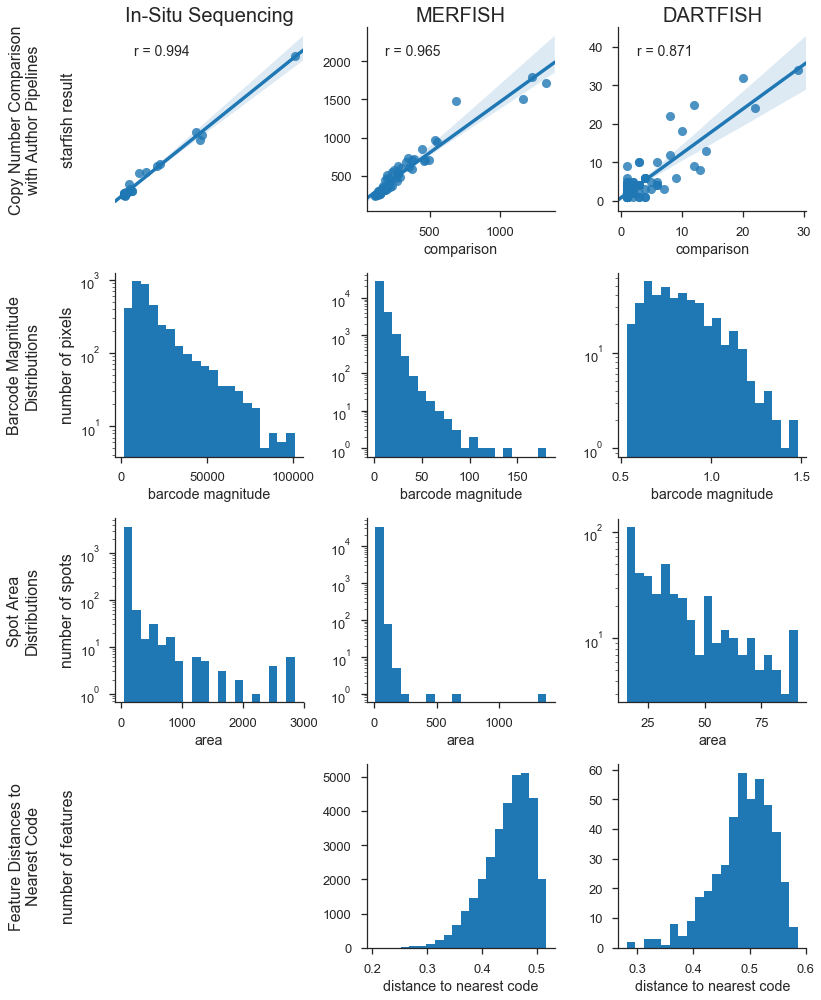

In [14]:
f, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 14))

for dataset, benchmark, axis in zip([iss, merfish, dartfish], [iss_copy_number, merfish_copy_number, dartfish_copy_number], axes[0, :]):
    compare_copy_number(dataset, benchmark, ax=axis, color='tab:blue')

for dataset, axis in zip(datasets, axes[1, :]):
    barcode_magnitude_histogram(dataset, bins=20, ax=axis)

for dataset, axis in zip(datasets, axes[2, :]):
    spot_area_histogram(dataset, bins=20, ax=axis)

for dataset, axis in zip([merfish, dartfish], axes[3, 1:]):
    spot_distance_histogram(dataset, bins=20, ax=axis)

# set the assay names as the titles of the top plots
axes[0, 0].set_title('In-Situ Sequencing', fontsize=20)
axes[0, 1].set_title('MERFISH', fontsize=20)
axes[0, 2].set_title('DARTFISH', fontsize=20);

# reset y-axis labels
for ax in np.ravel(axes):
    ax.set_ylabel('')
    
# reset titles
for ax in np.ravel(axes[1:, :]):
    ax.set_title('')

# set the y-axis labels
column_1_axes = (axes[:, 0])
plot_names = (
    'Copy Number Comparison\nwith Author Pipelines\n\nstarfish result\n\n',
    'Barcode Magnitude\nDistributions\n\nnumber of pixels',
    'Spot Area\nDistributions\n\nnumber of spots',
    'Feature Distances to\nNearest Code\n\nnumber of features\n\n'
)
for ax, name in zip(column_1_axes, plot_names):
    ax.set_ylabel(name, fontsize=16)


# fix up the figure
f.tight_layout()
for ax in np.ravel(axes):
    sns.despine(ax=ax)

# turn off the empty plots, matplotlib is super bad about this. 
for ax in (axes[3, 0], axes[0, 0]):
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)